Searching and downloading sentinel-2 data

In [1]:
import geopandas as gpd
import pandas as pd
from sentinelsat import SentinelAPI
import json
from datetime import date
from cartopy import crs, feature
ccrs = crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import shapely.geometry
from numpy.random import randint
import numpy as np
import rasterio 

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%config InlineBackend.figure_format = 'retina'

authinfo = json.loads(open("../passwords.json", 'r').read())

WA_extent = [-125.3759765625,-116.3562011719,49.4716937852,45.2632885315]

In [2]:
lakesdata = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDWaterbody.shp"
fcodes = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDFCode.dbf"
IMAGE_DOWNLOAD_DIR = '/Volumes/wrangell-st-elias/research/sentinel-2'

nhd_waterbody = gpd.read_file(lakesdata)
fcodes = gpd.read_file(fcodes)
nhd_waterbody_coded = pd.merge(nhd_waterbody,
                               fcodes.drop('geometry', axis=1), 
                               left_on='FCODE', right_on='FCODE',
                               how='left')

In [3]:
biglakes = nhd_waterbody_coded[(nhd_waterbody_coded.HYDROGRAPH == 'Perennial') & (nhd_waterbody_coded.AREASQKM > 10) & (nhd_waterbody_coded.AREASQKM < 20)]
len(biglakes)

18

In [4]:
api = SentinelAPI(authinfo['sentinel']['username'],authinfo['sentinel']['password'], 'https://scihub.copernicus.eu/dhus/')
whichlake = np.where(biglakes.index == biglakes[biglakes.GNIS_NAME == 'Lake Whatcom'].index[0])[0][0]#randint(0, len(biglakes))
print(whichlake)

2


In [5]:
products = api.query(biglakes.iloc[whichlake].geometry.envelope,
                     ('20161119', '20161225'),
                     platformname = 'Sentinel-2')
products = api.to_geodataframe(products)

In [6]:
products.index

Index(['1f28d037-1661-43f4-9738-889a92666828',
       '1f2b10ea-c6fa-4551-9f67-1d7bf6ab39d2',
       '41e68fb7-0de9-4b9e-8b1d-559b1593cba9',
       '43cdc654-9c86-4c40-8914-a89ba80bbbe3',
       '655a3d8c-dfa0-4fff-bb42-0ff8946998e7',
       '8e7f2e89-f4bd-42ce-bbd4-aa69f062f55f',
       '93b051ba-504c-4746-8f74-c422187d33aa',
       'b3be9a38-60ee-4237-81f3-f893b2f233c8',
       'bf038649-9397-4e37-a3b7-e4452fd335ed',
       'c62d9983-8e12-47d3-b364-ea439ebf44eb',
       'c79f246d-9a29-4bde-a299-6dc2600ce03a',
       'd59043b6-17c7-44ab-9216-14b52c25717c'],
      dtype='object')

In [7]:
print(products.crs)
print(products.total_bounds)
bounds = products.total_bounds

{'init': 'epsg:4326'}
[-123.00027708   47.75581865 -121.47940435   49.65272281]


In [8]:
cmap = plt.get_cmap('plasma')
min_datenum = mdates.date2num(products.ingestiondate.min())
max_datenum = mdates.date2num(products.ingestiondate.max())
cnormalizer = matplotlib.colors.Normalize(vmin=min_datenum, vmax=max_datenum)
cnormalizer(mdates.date2num(products.ingestiondate.max()))

1.0

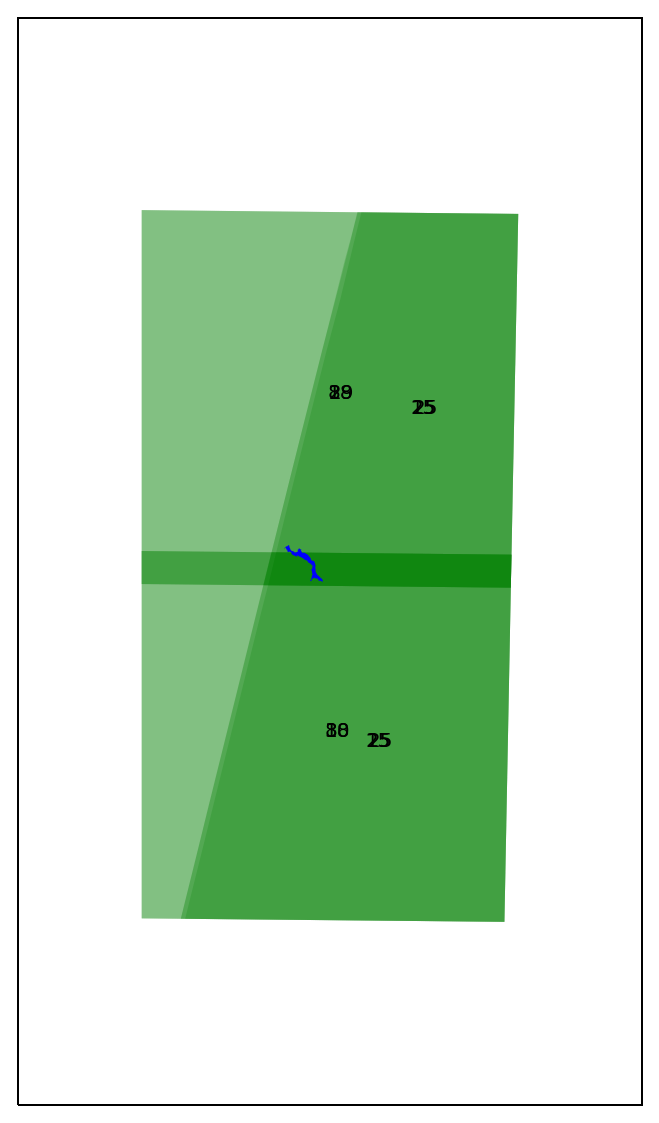

In [9]:
def plotGeomOnTiles(tiles, geom):
    bounds = tiles.total_bounds
    ax = plt.axes(projection=crs.Mercator().GOOGLE)
    ax.set_extent([bounds[2]+0.5, bounds[0]-0.5, bounds[1]-0.5, bounds[3]+0.5])
    states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none', name='admin_1_states_provinces_shp')
    ax.add_feature(states)


    #ax.add_geometries(products.geometry, crs=crs.PlateCarree(), facecolor=, alpha=0.2, label='sentinel')
    for i, shape in tiles.iterrows():
        middle = shape.geometry.centroid
        ax.text(middle.x, middle.y, shape['ingestiondate'].day, transform=crs.PlateCarree())
        coloridx = int(cnormalizer(mdates.date2num(shape.ingestiondate))*255)
        ax.add_geometries([shape.geometry], facecolor='green', crs=crs.PlateCarree(), alpha=0.2)
    ax.add_geometries([geom.buffer(0)], crs=crs.PlateCarree(), facecolor='blue', label='lake')
    ax.legend()


plotGeomOnTiles(products, biglakes.iloc[whichlake].geometry)

In [10]:
m = folium.Map([43, -120], zoom_start=6, control_scale=True)
for i, product in products.iterrows():
    c = folium.GeoJson(shapely.geometry.mapping(product.geometry), 
                       style_function = lambda feature: {'fillColor': '#ffaf00','color': 'blue', 'weight': 1.5,'dashArray': '5, 5'})#,highlight_function = lambda feature: {'fillColor': '#ffaf00','color': 'green', 'weight': 3,'dashArray': '5, 5'}
    print(product['ingestiondate'])
    c.add_child(folium.Popup(str(product['ingestiondate'])))
    c.add_to(m)

folium.GeoJson(shapely.geometry.mapping(biglakes.iloc[whichlake].geometry)).add_to(m)

2016-11-25 02:31:37.983000
2016-11-30 04:03:39.703000
2016-12-15 09:49:45.452000
2016-11-29 22:46:24.590000
2016-12-18 00:46:23.296000
2016-12-25 19:17:13.404000
2016-12-25 19:16:43.475000
2016-12-08 13:38:47.371000
2016-12-15 09:50:03.246000
2016-12-08 13:38:47.041000
2016-12-18 00:46:23.560000
2016-11-25 02:29:38.235000


In [11]:
m

---
ok so we can get images.

In [12]:
products.head()

,platformidentifier,relativeorbitnumber,platformserialidentifier,producttype,link_alternative,sensoroperationalmode,identifier,beginposition,cloudcoverpercentage,link,...,orbitnumber,processingbaseline,title,format,uuid,instrumentname,link_icon,size,processed,geometry
1f28d037-1661-43f4-9738-889a92666828,2015-000A,13,Sentinel-2A,S2MSI1C,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,INS-NOBS,S2A_OPER_PRD_MSIL1C_PDMC_20161125T015915_R013_...,2016-11-24 19:07:22.000,100.0000,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,...,7446,02.04,S2A_OPER_PRD_MSIL1C_PDMC_20161125T015915_R013_...,SAFE,1f28d037-1661-43f4-9738-889a92666828,Multi-Spectral Instrument,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,340.41 MB,F,POLYGON ((-122.5088155930985 48.66185179890427...
1f2b10ea-c6fa-4551-9f67-1d7bf6ab39d2,2015-000A,56,Sentinel-2A,S2MSI1C,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,INS-NOBS,S2A_OPER_PRD_MSIL1C_PDMC_20161130T001531_R056_...,2016-11-27 19:17:32.000,99.7972,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,...,7489,02.04,S2A_OPER_PRD_MSIL1C_PDMC_20161130T001531_R056_...,SAFE,1f2b10ea-c6fa-4551-9f67-1d7bf6ab39d2,Multi-Spectral Instrument,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,611.33 MB,F,"POLYGON ((-123.0002720958938 48.7530130044756,..."
41e68fb7-0de9-4b9e-8b1d-559b1593cba9,2015-000A,13,Sentinel-2A,S2MSI1C,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,INS-NOBS,S2A_MSIL1C_20161214T190802_N0204_R013_T10UEV_2...,2016-12-14 19:08:02.026,68.3014,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,...,7732,02.04,S2A_MSIL1C_20161214T190802_N0204_R013_T10UEV_2...,SAFE,41e68fb7-0de9-4b9e-8b1d-559b1593cba9,Multi-Spectral Instrument,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,447.20 MB,NaN,"POLYGON ((-122.508690836681 48.66185099175762,..."
43cdc654-9c86-4c40-8914-a89ba80bbbe3,2015-000A,56,Sentinel-2A,S2MSI1C,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,INS-NOBS,S2A_OPER_PRD_MSIL1C_PDMC_20161129T211821_R056_...,2016-11-27 19:17:32.000,99.6002,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,...,7489,02.04,S2A_OPER_PRD_MSIL1C_PDMC_20161129T211821_R056_...,SAFE,43cdc654-9c86-4c40-8914-a89ba80bbbe3,Multi-Spectral Instrument,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,636.83 MB,F,POLYGON ((-123.0002770774474 49.65272281450567...
655a3d8c-dfa0-4fff-bb42-0ff8946998e7,2015-000A,56,Sentinel-2A,S2MSI1C,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,INS-NOBS,S2A_MSIL1C_20161217T191812_N0204_R056_T10UEV_2...,2016-12-17 19:18:12.026,61.3319,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,...,7775,02.04,S2A_MSIL1C_20161217T191812_N0204_R056_T10UEV_2...,SAFE,655a3d8c-dfa0-4fff-bb42-0ff8946998e7,Multi-Spectral Instrument,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,808.65 MB,NaN,POLYGON ((-123.0002770774474 49.65272281450567...


get only the ones that overlap completely:

In [13]:

containslake = products[products.contains(biglakes.iloc[whichlake].geometry)]

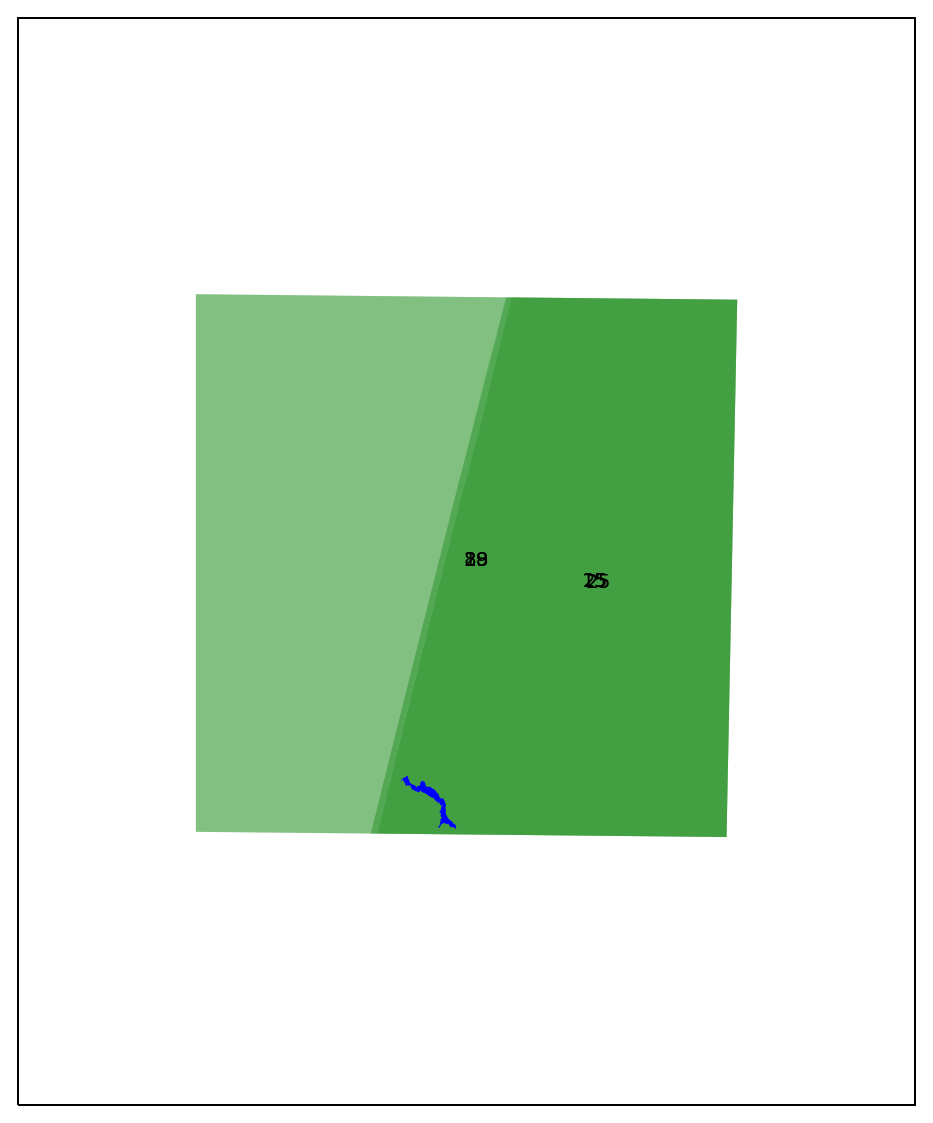

In [14]:
plotGeomOnTiles(containslake, biglakes.iloc[whichlake].geometry)

In [15]:
most_recent = containslake[containslake.ingestiondate == containslake.ingestiondate.max()]
most_recent.index

Index(['93b051ba-504c-4746-8f74-c422187d33aa'], dtype='object')

In [16]:
imagedownload = api.download_all(most_recent.index, directory_path=IMAGE_DOWNLOAD_DIR)

In [18]:
thislake = biglakes.iloc[whichlake]
thislake.GNIS_NAME

'Lake Whatcom'

--- 
load image

In [19]:
import zipfile
file = zipfile.ZipFile(imagedownload[0]['93b051ba-504c-4746-8f74-c422187d33aa']['path'], 'r')
#print(imagedownload[0]['93b051ba-504c-4746-8f74-c422187d33aa']['path'].split('.')[0]+'22')
file.extractall(IMAGE_DOWNLOAD_DIR)


In [48]:
import glob
from skimage import exposure, img_as_ubyte
base_filename = imagedownload[0]['93b051ba-504c-4746-8f74-c422187d33aa']['path'].split('.')[0]

imagedir = "%s.SAFE/GRANULE/*/IMG_DATA/*B%02d.jp2" % (base_filename, 1)
natcolor_imagedir =  "%s.SAFE/GRANULE/*/IMG_DATA/natcolor.tif" % (base_filename)

natcolor = rasterio.open(glob.glob(natcolor_imagedir)[0])
b1 = rasterio.open(glob.glob("%s.SAFE/GRANULE/*/IMG_DATA/*B%02d.jp2" % (base_filename, 4))[0])
b4 = rasterio.open(glob.glob("%s.SAFE/GRANULE/*/IMG_DATA/*B%02d.jp2" % (base_filename, 3))[0])
b3 = rasterio.open(glob.glob("%s.SAFE/GRANULE/*/IMG_DATA/*B%02d.jp2" % (base_filename, 2))[0])

In [49]:
print(base_filename)

/Volumes/wrangell-st-elias/research/sentinel-2/S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_20161224T190807


ImportError: cannot import name 'stack'

In [50]:
b1_im = b1.read()
b4_im = b4.read()
b3_im = b3.read()

print(b1_im.shape)
print(b4_im.shape)
print(b3_im.shape)

b1_im = np.transpose(b1_im, [1,2,0])
b4_im = np.transpose(b4_im, [1,2,0])
b3_im = np.transpose(b3_im, [1,2,0])

stack = np.stack([b1_im, b4_im, b3_im], axis=2)
stack = img_as_ubyte(stack)
p2, p98 = np.percentile(stack, (2, 98))
stack = exposure.rescale_intensity(stack, in_range=(p2, p98))#stack = b4_im

(1, 10980, 10980)
(1, 10980, 10980)
(1, 10980, 10980)


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [51]:
src = b1
xmin = src.transform[0]
xmax = src.transform[0] + src.transform[1]*src.width
ymin = src.transform[3] + src.transform[5]*src.height
ymax = src.transform[3]

/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [52]:
crs = ccrs.epsg(src.crs['init'].split(':')[1])

In [53]:
crs

_EPSGProjection(32610)

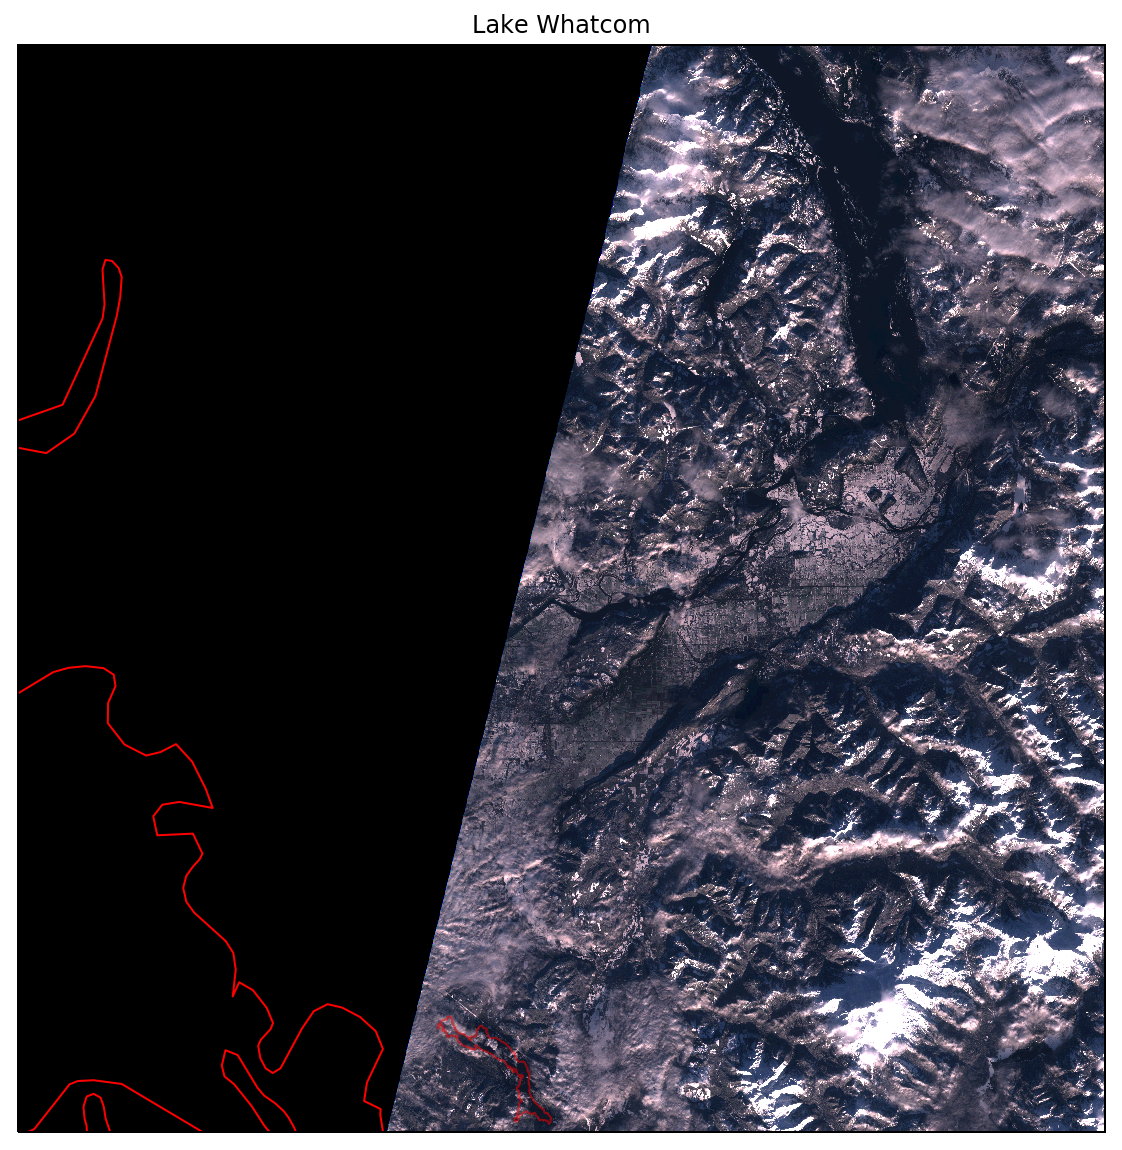

In [55]:
ax = plt.axes(projection=crs)
plt.title(thislake.GNIS_NAME)
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
plt.imshow(np.squeeze(stack), origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
ax.coastlines(resolution='10m', color='red', linewidth=1)
ax.add_geometries([biglakes.iloc[whichlake].geometry.buffer(0)], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', label='lake', alpha=0.5, )
plt.savefig('test.png')

array([[[[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        ..., 
        [[ 87],
         [ 87],
         [111]],

        [[103],
         [ 95],
         [119]],

        [[103],
         [103],
         [119]]],


       [[[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        ..., 
        [[ 95],
         [ 95],
         [111]],

        [[103],
         [ 95],
         [119]],

        [[103],
         [ 95],
         [119]]],


       [[[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        [[  0],
         [  0],
         [  0]],

        ..., 
        [[ 87],
         [ 87],
         [111]],

        [[ 95],
         [ 95],
         [119]],

        [[ 95],
         [ 95],
         [119]]],


       ..., 
       [[[  0],
         [  0],
       

In [81]:
from rasterio import mask
import fiona
?fiona.

In [68]:
natcolor = rasterio.open("/Volumes/wrangell-st-elias/research/sentinel-2/S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_20161224T190807.SAFE/GRANULE/L1C_T10UEV_A007875_20161224T190807/IMG_DATA/natcolor.tif")

In [109]:
from functools import partial
import pyproj
from shapely.ops import transform

geom = biglakes.iloc[whichlake].geometry

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init=natcolor.crs['init'])) # destination coordinate system

g2 = transform(project, geom)  # apply projection

out_image, out_transform = mask.mask(natcolor, [shapely.geometry.mapping(g2)], crop=True)
out_meta = natcolor.meta.copy()

In [132]:

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with MemoryFile(**out_meta) as memfile:
    while True:
        memfile.write(out_image)
    with memfile.open(**out_meta) as dataset:
        data_array = dataset.read()
# with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

ImportError: cannot import name 'io'

In [124]:
a = rasterio.open("RGB.byte.masked.tif")

In [125]:
a_im = a.read()

In [126]:
a_im = np.transpose(a_im, [1,2,0])
a_im = img_as_ubyte(a_im)
p2, p98 = np.percentile(a_im, (2, 98))
a_im = exposure.rescale_intensity(a_im, in_range=(p2, p98))#stack = b4_im
print(a_im.shape)

(1086, 1147, 3)


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [127]:
src = a
xmin = src.transform[0]
xmax = src.transform[0] + src.transform[1]*src.width
ymin = src.transform[3] + src.transform[5]*src.height
ymax = src.transform[3]
crs = ccrs.epsg(src.crs['init'].split(':')[1])


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


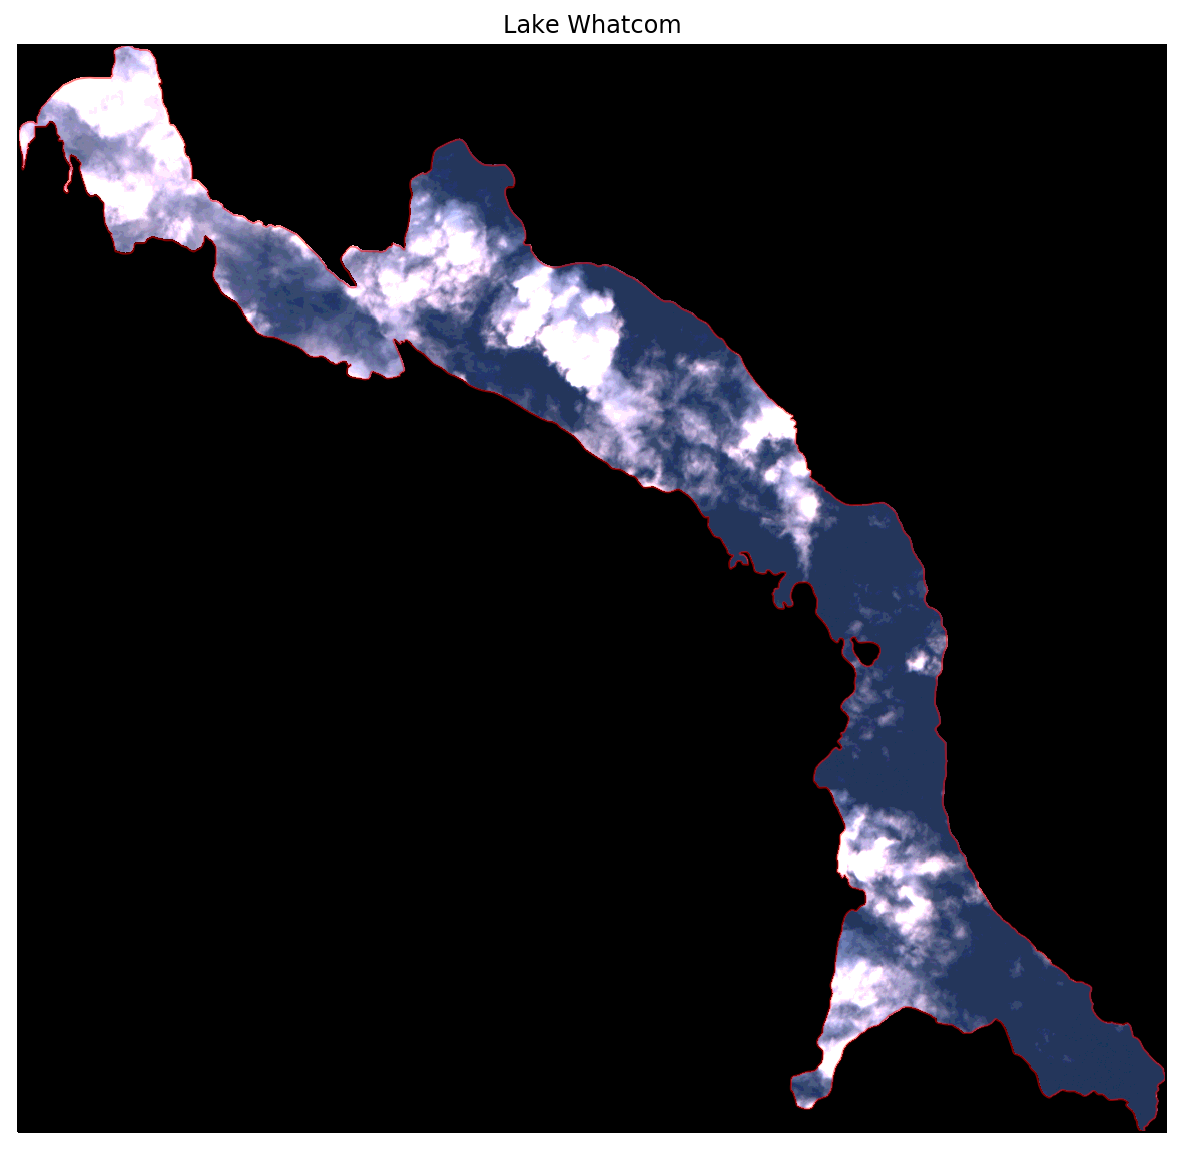

In [128]:
ax = plt.axes(projection=crs)
plt.title(thislake.GNIS_NAME)
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
plt.imshow(np.squeeze(a_im), origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
ax.coastlines(resolution='10m', color='red', linewidth=1)
ax.add_geometries([biglakes.iloc[whichlake].geometry.buffer(0)], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', label='lake', alpha=0.5, )
plt.savefig('test.png')